In [62]:
# 一维码瑕疵检测

import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy

In [63]:
# Function

def get_norm(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    minG = gray.min()
    maxG = gray.max()
    norm = (gray - minG) / (maxG - minG) # 将图像归一化
    norm = np.uint8(norm * 255.0)
    norm = cv2.bilateralFilter(norm, 5, 50, 100)
    # norm = np.uint8(guideFilter(norm, (5, 5), 3) * 255)
    return norm

def unsharp_mask(image, sigma=1.0, strength=1.5, threshold=5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)
    mask = np.abs(image - blurred) >= threshold
    sharpened_image = np.where(mask, sharpened, image)
    return sharpened_image


def multiply(img1, img2):#正片叠底
    img1 = img1 / 255.0
    img2 = img2 / 255.0
    res = np.multiply(img1, img2)
    res = (res * 255).astype(np.uint8)
    return res

def get_min_area_box(norm):
    _, thresh = cv2.threshold(norm, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    h, w = thresh.shape[:2]
    xids = []
    yids = []
    for i in range(h):
        for j in range(w):
            if thresh[i][j] == 0:
                xids.append(j)
                yids.append(i)
    xmin = min(xids)
    ymin = min(yids)
    xmax = max(xids)
    ymax = max(yids)
    return norm[ymin:ymax, xmin:xmax], (xmin, ymin, xmax, ymax)

def canny_detect(norm):
    canny = cv2.Canny(norm, 100, 200)
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    keep_conts = [] # 报错检测出的缺陷点
    for cont in contours:
        # x, y, w, h = cv2.boundingRect(cont)
        (x, y), (w, h), a = cv2.minAreaRect(cont)
        # epsilon = 0.01 * perimeter
        # approx = cv2.approxPolyDP(cont, epsilon, True)
        # hull = cv2.convexHull(cont)
        # defect = cv2.convexityDefects(cont, hull)
        if 2 <= w < 20 and 2 <= h < 20: # 面积过滤
            if max(w, h) / min(w, h) > 3: # 过滤宽高比
                continue
            # perimeter = cv2.arcLength(cont, True)  # 轮廓周长
            # print(perimeter)
            # perimeter = cv2.arcLength(cont, False)  # 轮廓周长
            # print(perimeter)
            keep_conts.append(cont)
            # if canvas is not None:
            #     canvas = cv2.drawContours(canvas, [cont], -1, (0, 255, 0), 1)
    return keep_conts

def hash_feature(norm):
    ''' 
    1.每一列所属为黑(0)还是白(255)
      计算每一列均值，大于均值为白(1),小于均值为黑(0)
    2.提取色块区间
      计算行连续区间所属类别
    '''
    # 对每一列分类，计算每一列均值，大于均值为白(1),小于均值为黑(0)
    flat = np.mean(norm, 0) / 255.0  # 纵向拉平
    flat_cls = np.where(flat > np.mean(flat), 1, 0)
    width = len(flat_cls)
    # 从左向右,将连续列索引划分所属区间
    hashed_list = [] # eg. [(0, [0,1,2]), (1, [4,5,6])]
    indices = [0]
    for i in range(1, width):
        if flat_cls[i - 1] != flat_cls[i]:
            hashed_list.append((flat_cls[i - 1], deepcopy(indices)))
            indices = []
        indices.append(i)
    if len(indices) > 0:
        hashed_list.append((flat_cls[-1], deepcopy(indices)))
    return hashed_list

def thinline(norm, hashed_list, min_thresh=2, max_thresh=200):
    defect = np.zeros_like(norm)
    for (cls, region) in hashed_list:
        s = region[0]
        e = region[-1]
        w = e - s
        if w < min_thresh or w > max_thresh:
            defect[:, s:e] = 1
    return defect

def projection(norm, hashed_list):
    defect = np.zeros_like(norm)
    for (cls, region) in hashed_list:
        roi = norm[:, region] # 仅提取当前色块
        m = (roi.max() + roi.min()) / 2
        roi_bin = np.uint8(np.where(roi > m, 1, 0)) # 判断所属类别
        roi_mask = np.where(roi_bin != cls, 1, 0) # 和当前色块类型不一致的为1
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(roi_bin, connectivity=4)
        labels += 1 # 面积最大的（0）也有可能是缺陷
        for i in range(num_labels):
            # 过滤不是缺陷的labels
            matched = False
            x, y, cw, ch, area = stats[i]
            if area < 10:
                matched = True
            if y < 10 and ch < 10:
                matched = True
            if y > (roi.shape[0] - 10) and ch < 10:
                matched = True
            # 不是缺陷的区域置0
            if matched:
                ids = np.where(labels == (i + 1))
                labels[ids] = 0
        defect[:, region] = labels * roi_mask
    defect = np.where(defect != 0, 1, 0)
    return defect

# 整体算法思路

1. 预处理

- 标准化
- usm锐化

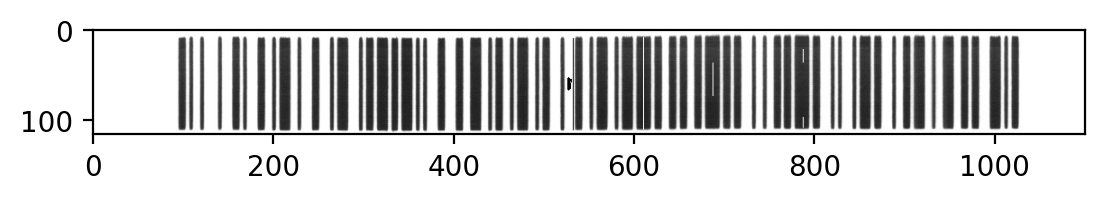

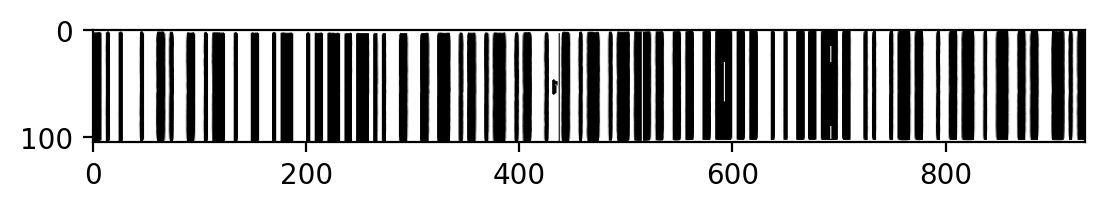

In [64]:
image = cv2.imread(r'images3/WechatIMG873.jpeg')
image = image[30:145, 100:1200]
h, w = image.shape[:2]
plt.figure(dpi=200)
plt.imshow(image, cmap='gray')
plt.show()

# 预处理
norm = get_norm(image)
norm = unsharp_mask(norm, 25)
norm, rect = get_min_area_box(norm)
plt.figure(dpi=200)
plt.imshow(norm, cmap='gray')
plt.show()

2. 将一维码关键信息解构

- 将一维码视为从左向右依次由黑块和白块排列的图案
- 通过均值，计算每一列所属的类别，黑(0)，白(1)
- 合并相同类别的相邻列，组合成一个个黑白色块
- 保存结构信息为hashed_list：，每一个元素由(类别，列索引)组成，如：[(白, [0,1,2]), (黑, [3,4,5]), (白, [5,6,7])]

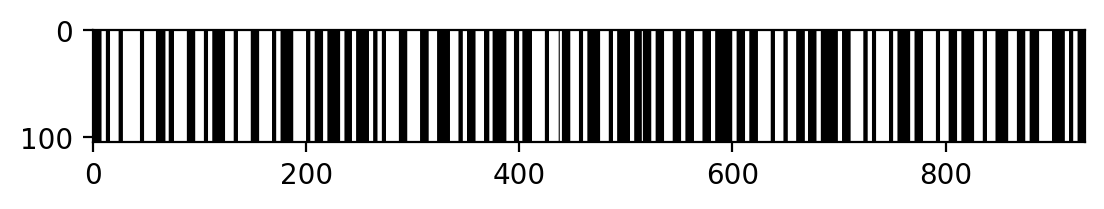

In [65]:
# 黑白条归类
hashed_list = hash_feature(norm)
# print(hashed_list)
# 测试
canvas = np.ones_like(norm, dtype='uint8') * 255
for (cls, region) in hashed_list:
    canvas[:, region] = cls
plt.figure(dpi=200)
plt.imshow(canvas, cmap='gray')
plt.show()

3. 对每一个色块进行缺陷检测

- 投影检测：黑中白，白中黑

/Users/blank/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: overflow encountered in ubyte_scalars


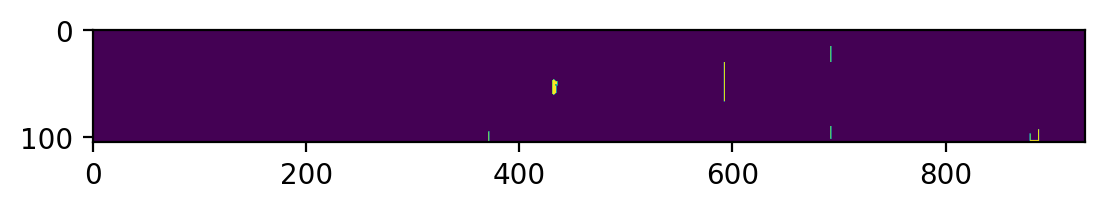

In [66]:
defect_1 = projection(norm, hashed_list)
plt.figure(dpi=200)
plt.imshow(defect_1)
plt.show()

- 计算色块宽度，小于或者大于一定阈值的，为异常色块

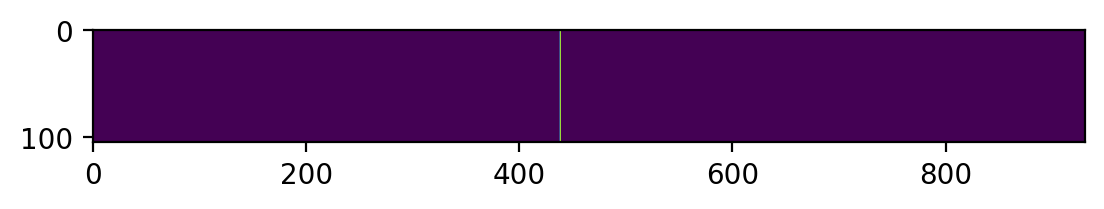

In [67]:
defect_2 = thinline(norm, hashed_list)
plt.figure(dpi=200)
plt.imshow(defect_2)
plt.show()

# 合并缺陷并输出最终结果

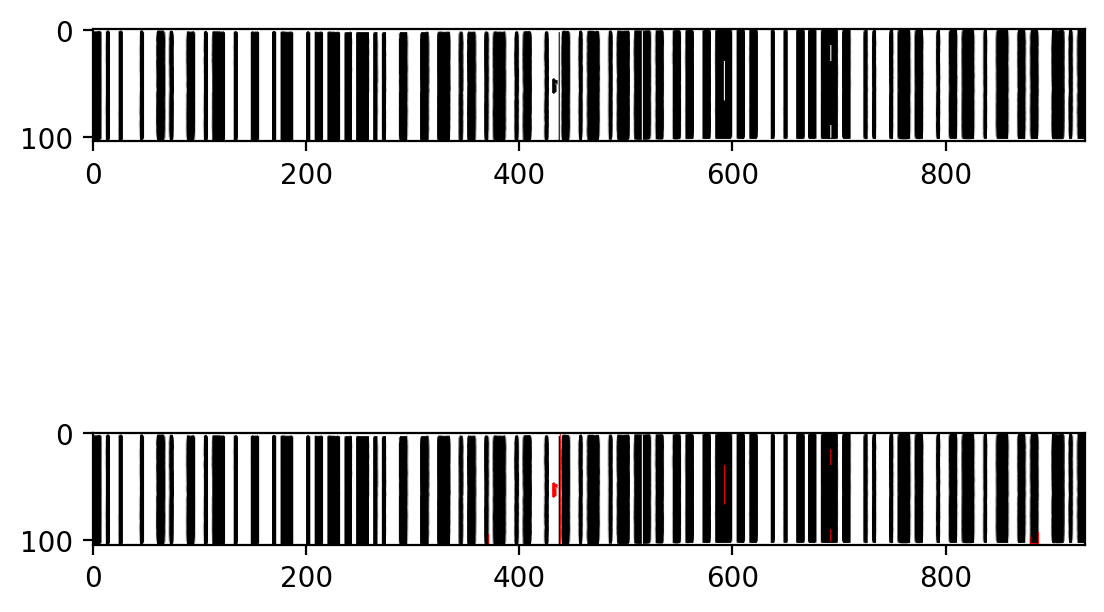

In [68]:
defect = defect_1 + defect_2
result = cv2.cvtColor(norm.copy(), cv2.COLOR_GRAY2BGR)
result[np.where(defect == 1)] = [255, 0, 0]

plt.figure(dpi=200)
plt.subplot(211)
plt.imshow(norm, cmap='gray')

plt.subplot(212)
plt.imshow(result)
plt.show()